# Plot Analysis For LSTM Model
This jupyter notebook includes all the code used for makigng various plots associated with the LSTM Model training and analysis. 

In [1]:
%matplotlib inline
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import r2_score 
from math import log
import time
print(tf.__version__)

2.2.0


# Discretising the data
To reduce the computational load of the problem, we have only taken data at every 1% strain step instead of all timesteps for which the FE Simulation runs. The snippet below input the data file and looks for timesteps with 1% increment in applied strain and stores them. 

- `out_file["eff_strain"]` - contains all values of applied strain at every timestep, we look for timesteps at which there is 1\% increment in strain and record them. 
- `df` - contains all the data as read from the FE output file.
- `df_steps` - contains the data only at 1\% strain steps 
- `df_steps_norm` - contains the normalised data only at 1\% strain steps

In [2]:
out_file = pd.read_csv('data/AR1/out.csv')
lim = 0.01
timesteps = []
time = []
for i in range(len(out_file)):
    if(out_file["eff_strain"][i] > lim):
        timesteps.append(i+1)
        time.append(out_file["time"][i])
        lim = lim + 0.01
steps = np.ceil((np.array(timesteps)/50))

# Reading data
df = pd.read_csv('data/AR1/out_soudip.csv')
df_dropped = df.drop(columns=['sdv22', 'sdv23', 'total_strain_xy', 'elem_id', 'blk_id'])
df_norm = (df_dropped-df_dropped.min())/(df_dropped.max()-df_dropped.min())

df_steps = df_dropped[df_dropped["time"].isin(steps)]
df_steps_norm = (df_steps-df_steps.min())/(df_steps.max()-df_steps.min())
df_group = df_steps_norm.groupby(["elem_x", "elem_y"])

# Structuring Data
As LSTM is used for sequence prediction. Even though the data we have is 2D spatio temporal data, it can be restructured to be a simple sequence prediction problem, where we have 3 different variables and 16,000 elements. Each variable and element's value evolves over time, giving us a total of 16,000\*3 = 48,000 sequences. We have taken data for 15 timesteps, (0, 0.01\%, ...0.15\% strains), hence each sequences is of the length 15. Below, the data is arranged in to sequences and prepared for training. The data has the shape 48,000\*15. 

`raw` - contains the sequences 

In [3]:
raw = pd.DataFrame()
for name, group in df_group:
    col = 'elem_%1.3f_%1.3f_strain' % name
    val = group['eff_strain'].values
    raw[col] = val
print("Strain done")
for name, group in df_group:
    col = 'elem_%1.3f_%1.3f_stress' % name
    val = group['vonmises'].values
    raw[col] = val
print("Vonmises done")
for name, group in df_group:
    col = 'elem_%1.3f_%1.3f_triaxiality' % name
    val = group['triaxiality'].values
    raw[col] = val
print("Triaxiality done")

Strain done
Vonmises done
Triaxiality done


# Preparing data for supervised learning
Supervised learning, as the name indicates, has the presence of a supervisor as a teacher. Basically supervised learning is when we teach or train the machine using data that is well labeled. Our model is designed such that it takes the input for all the variables for each elements at timestep t and makes a prediction for values at t+1. 
For a given strain step, t, 48,000 length vector X<sub>t</sub> is input to the LSTM model and used to predict the output vector, Y<sub>t</sub> which consists of values at the next strain step in the series X<sub>t</sub>. The structure of the data can be better understood through the table below

| Input | Output |
| :---: | :-----: |
| X<sub>1</sub> | X<sub>2</sub> |
| X<sub>2</sub> | X<sub>3</sub> |
| X<sub>3</sub> | X<sub>4</sub> |
| . | . |
| . | . |
| . | . |
| X<sub>10</sub> | X<sub>11</sub> |

- `train_X`, `train_y`: Out of the total 15 strain steps, 70\% are used for training. 
- `val_X`, `val_y`: The remaining 30\%, used for testing the model's performance on data it hasn't seen before.

In [4]:
def series_to_supervised(sequences, n_steps_in, n_steps_out, dropnan=True):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix: out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
        
n_steps_in, n_steps_out = 1, 1
x, y = series_to_supervised(raw.values, n_steps_in, n_steps_out)
print(x.shape, y.shape)

n = len(x)
train_X, train_y = x[0:int(n*0.7)], y[0:int(n*0.7)]
val_X, val_y = x[int(n*0.7):], y[int(n*0.7):]



(15, 1, 480000) (15, 1, 480000)


# Loading the model and predicting
The model previously trained and saved is loaded for making prediction and analysis

- `pred_Y`: values as predicted by the LSTM model. It is a 3D tensor.
- `plot_pred`: `pred_Y` reduced to a 2D tensor as needed for further plotting
- `plot_y_fe`: the FE values at all the timesteps

In [9]:
model_number = 34
base_path = './trained_models/lstm_model_%i' % (model_number)
model = tf.keras.models.load_model(base_path+'/the_model')

pred_Y = model.predict(train_X)
plot_pred = pred_Y.reshape((10, 480000))
plot_y_fe = y.reshape(15, 480000)

# Strain partitioning plot
Strain parititioning is commonly observed in dual phase microstructures. Strain partitioning plots shows the comparison of the LSTM predicted and FE predicted average effective strains in the soft and hard phases as a function of applied strain. The following few code snippets extract the data needed for these plots.

In our exodus file, the grain id are called `blk_id`. In the snippet below we store the grain ids for every elements in the other in which they appear in the microstructure. 

`blk_id_ordered`: list of grain id of all elements, in the order they appear on the microstructure

In [10]:
blk_group = df.groupby(["elem_x", "elem_y"])
blk_id_ordered = []
for name, group in blk_group:
    blk_id_ordered.append(group['blk_id'].values[0])

## Effective Strain Values
Effective strain values for each of the phases are calculated in the snippet below. Grain id greater than 1677 belong to the martensite phase. For every timestep, the strain values for both the phases are caculated and stored from the LSTM predictions 

- `one_step`: a vector with values for all the 16,000 elements at a particular timestep.
- `one_step_scaled`: vector with effective strain values for every element at a single timestep on the standard scale.
- `martensite_step`: summation of strain values for all the martensite (hard) phase elements at a single timestep
- `ferrite_step`:  summation of strain values for all the ferrite (soft) phase elements at a single timestep
- `martensite_count`: number of martensite (hard) elements
- `ferrite_count`: numbero of ferrite (soft) elements
- `martensite_strain_steps`: list of average strain values of martensite (hard) elements at all timesteps
- `ferrite_strain_steps`: list of average strain values of ferrible (soft) elements at all timesteps

In [11]:
martensite_strain_steps = [0]
ferrite_strain_steps = [0]
for j in range(1,11):
    one_step = plot_pred[j-1:j][:,:160000]
    var_name = 'eff_strain'
    one_step_scaled = (one_step*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
    martensite_step = 0
    ferrite_step = 0
    martensite_count = 0
    ferrite_count = 0
    for i in range(len(one_step_scaled[0])):
        #print(i)
        if blk_id_ordered[i] > 1677:
            martensite_step += one_step_scaled[0][i]
            martensite_count += 1
        elif blk_id_ordered[i] <= 1677:
            ferrite_step += one_step_scaled[0][i]
            ferrite_count += 1
    martensite_strain_steps.append(martensite_step/martensite_count)
    ferrite_strain_steps.append(ferrite_step/ferrite_count)

pred_Y_test = model.predict(val_X)
plot_pred_test = pred_Y_test.reshape((5, 480000))
for j in range(1,6):
    one_step = plot_pred_test[j-1:j][:,:160000]
    var_name = 'eff_strain'
    one_step_scaled = (one_step*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
    
    print(len(one_step_scaled[0]))
    martensite_step = 0
    ferrite_step = 0
    martensite_count = 0
    ferrite_count = 0
    for i in range(len(one_step_scaled[0])):
        #print(i)
        if blk_id_ordered[i] > 1677:
            martensite_step += one_step_scaled[0][i]
            martensite_count += 1
        elif blk_id_ordered[i] <= 1677:
            ferrite_step += one_step_scaled[0][i]
            ferrite_count += 1
    martensite_strain_steps.append(martensite_step/martensite_count)
    ferrite_strain_steps.append(ferrite_step/ferrite_count)

160000
160000
160000
160000
160000


## Plotting
The actual plotting takes place in the snippets below.

- `martensite`: FE values for the martensite (hard) phase 
- `ferrite`: FE values for the ferrite (soft) phase
- `martensite_strain`: FE effective strain values for the martensite (hard) phase at all timesteps
- `ferrite_strain`: FE effective strain values for the ferrite (soft) phase at all timesteps

In [12]:
strain_yy_steps = df_steps.strain_yy.unique()
strain_yy_steps[0] = 0
martensite = df.loc[df['blk_id']>1677]
ferrite = df.loc[df['blk_id']<=1677]

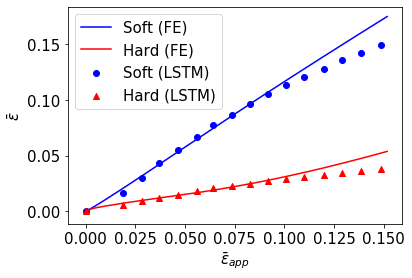

In [13]:
martensite_strain = martensite.groupby('time').mean()['eff_strain']
strain_yy = df.groupby('time').mean()['strain_yy']
ferrite_strain = ferrite.groupby('time').mean()['eff_strain']


plt.figure()
plt.rcParams.update({'font.size': 15})
plt.plot(strain_yy, ferrite_strain, 'b', label='Soft (FE)')
plt.scatter(strain_yy_steps, ferrite_strain_steps, marker='o', c='blue', label="Soft (LSTM)")
plt.plot(strain_yy, martensite_strain, 'r', label="Hard (FE)")
plt.scatter(strain_yy_steps, martensite_strain_steps, marker='^', c='red', label="Hard (LSTM)")
plt.xlabel(r'$\bar{\epsilon}_{app}$')
plt.ylabel(r'$\bar{\epsilon}$')
plt.legend()
plt.savefig('./strain_paritioning.png', dpi=700, bbox_inches="tight")

# Stress Strain Curve
The following code plots the stress strain curve for both FE values and the LSTM predictions.

- `one_step`: a vector with values for all the 16,000 elements at a particular timestep.
- `one_step_scaled`: vector with effective strain values for every element at a single timestep on the standard scale.
- `strain_steps`: predicted effective strain values at all timesteps
- `stress_steps`: predicted von mises stress values at all timesteps.

1.0


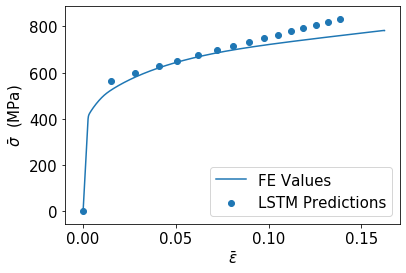

In [15]:
strain_steps = [0]
stress_steps = [0]
for i in range(1,11):
    one_step = plot_pred[i-1:i][:,:160000]
    var_name = 'eff_strain'
    one_step_scaled = (one_step*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
    strain_steps.append(sum(one_step_scaled[0])/160000)
    
    var_name = 'vonmises'
    one_step = plot_pred[i-1:i][:,160000:320000]
    one_step_scaled = (one_step*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
    stress_steps.append(sum(one_step_scaled[0])/160000)

pred_Y_test = model.predict(val_X)
plot_pred_test = pred_Y_test.reshape((5, 480000))
for i in range(1,6):
    one_step = plot_pred_test[i-1:i][:,:160000]
    var_name = 'eff_strain'
    one_step_scaled = (one_step*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
    strain_steps.append(sum(one_step_scaled[0])/160000)
    var_name = 'vonmises'
    one_step = plot_pred_test[i-1:i][:,160000:320000]
    one_step_scaled = (one_step*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
    stress_steps.append(sum(one_step_scaled[0])/160000)  

df = pd.read_csv('~/projects/model_training/data/AR2/out.csv')
plt.figure()
plt.rcParams.update({'font.size': 15})
plt.plot(df['eff_strain'], df['vonmises'], label='FE Values')
plt.xlabel(r'$\bar{\epsilon}$')
plt.ylabel(r'$\bar{\sigma}$  (MPa)')
plt.scatter(strain_steps, stress_steps, label='LSTM Predictions')
plt.legend()
plt.savefig(base_path+'/pred_stress_strain.png', dpi=700, bbox_inches="tight")
print(sum(one_step_scaled[0].shape)/160000)

# Contour Plots
Contour plots have been drawn for all the 3 predicted variables: effective strain, vonmises, strain triaxiality. Three plots have been shown

- FE Values: True values as computed by the FE Simulations at the last time step
- LSTM Values: Predicted values as computed by the LSTM model at the last time step
- Error Values: Difference between the FE values and LSTM values for every element

In [22]:
pred_Y = model.predict(val_X)
plot_pred = pred_Y.reshape((5, 480000))
plot_y_fe = y.reshape(15, 480000)

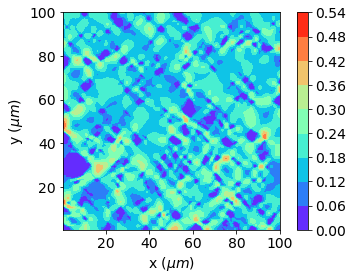

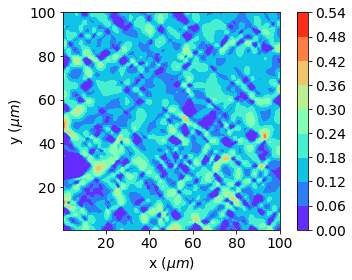

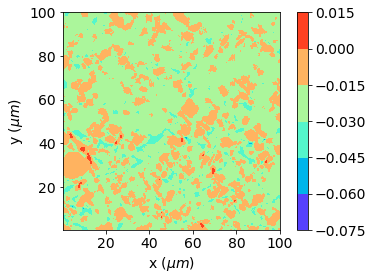

In [23]:
var_name = 'eff_strain'
plot_y_fe_scaled = plot_y_fe[-1:][:,:160000]
plot_y_fe_scaled = (plot_y_fe_scaled*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
yy_levels = [0.00, 0.06, 0.12, 0.18, 0.24, 0.30, 0.36, 0.42, 0.48, 0.54]

# Contour of FE Values
xlist = np.arange(0.25, 100.25, 0.25)
ylist = np.arange(0.25, 100.25, 0.25)
X,Y = np.meshgrid(xlist, ylist)
Z = plot_y_fe_scaled.reshape(400, 400)
fig,ax=plt.subplots(1,1)
plt.rcParams.update({'font.size': 14})
mycmap1 = plt.get_cmap('rainbow')
cp = ax.contourf(X, Y, Z, cmap=mycmap1)
cbar = fig.colorbar(cp) # Add a colorbar to a plot
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('x ($\mu m$)')
ax.set_ylabel('y ($\mu m$)')
plt.savefig(base_path+'/contour_cpfe_square'+var_name+'.eps', format='eps')

# Contour of LSTM Values
var_name = 'eff_strain'
plot_pred_scaled = plot_pred[-1:][:,:160000]
plot_pred_scaled = (plot_pred_scaled*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
xlist = np.arange(0.25, 100.25, 0.25)
ylist = np.arange(0.25, 100.25, 0.25)
X,Y = np.meshgrid(xlist, ylist)
Z = plot_pred_scaled.reshape(400, 400)
fig,ax=plt.subplots(1,1)
plt.rcParams.update({'font.size': 14})
mycmap1 = plt.get_cmap('rainbow')
cp = ax.contourf(X, Y, Z, cmap=mycmap1, levels=yy_levels)
fig.colorbar(cp) 
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('x ($\mu m$)')
ax.set_ylabel('y ($\mu m$)')
plt.savefig(base_path+'/contour_pred_square_'+var_name+'.eps', format='eps')

# Contour of Error Values
plot_diff = (plot_pred_scaled - plot_y_fe_scaled)
xlist = np.arange(0.25, 100.25, 0.25)
ylist = np.arange(0.25, 100.25, 0.25)
X,Y = np.meshgrid(xlist, ylist)
Z = plot_diff.reshape(400, 400)
fig,ax=plt.subplots(1,1)
plt.rcParams.update({'font.size': 14})
mycmap1 = plt.get_cmap('rainbow')
cp = ax.contourf(X, Y, Z, cmap=mycmap1)
fig.colorbar(cp) 
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('x ($\mu m$)')
ax.set_ylabel('y ($\mu m$)')
plt.savefig(base_path+'/contour_error_square'+var_name+'.eps', format='eps')

# Cross correlation plot
Plot of LSTM predicted values vs FE values. 

[0.8975304331724107] 0.08496770503451358


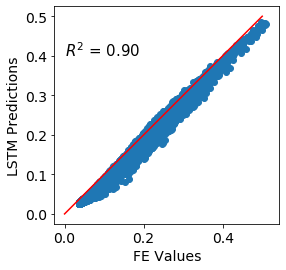

In [24]:
r2 = []
test_vec = plot_pred_scaled.reshape(1, 160000)[0]
pred_vec = plot_y_fe_scaled.reshape(1, 160000)[0]
r2.append(r2_score(pred_vec, test_vec))
err1 = sum(abs(pred_vec-test_vec))/40000
print(r2, err1)

plt.figure()
plt.rcParams.update({'font.size': 14})
a = plt.axes(aspect='equal')
a.text(0,0.4, "$R^2$ = %0.2f"%(r2[0]), fontsize=15)
plt.scatter(plot_y_fe_scaled.reshape(1, 160000), plot_pred_scaled.reshape(1, 160000))
xp = [0,0.5]
yp = xp
plt.plot(xp,yp, 'r')
plt.xlabel('FE Values')
plt.ylabel('LSTM Predictions')
plt.savefig(base_path+"/"+var_name+"-10-nohead.eps", format='eps')

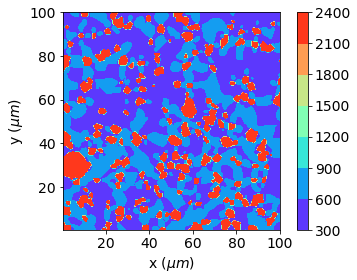

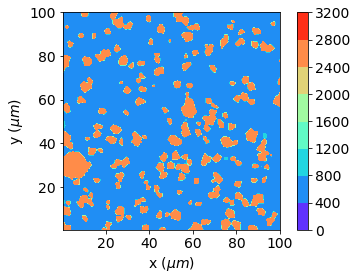

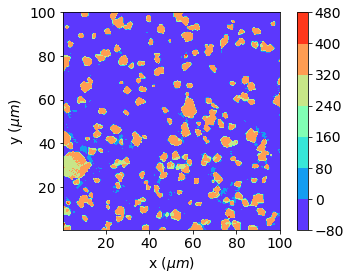

In [25]:
var_name = 'vonmises'
plot_y_fe_scaled = plot_y_fe[-1:][:,160000:320000]
plot_y_fe_scaled = (plot_y_fe_scaled*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()

yy_levels = np.array([300, 600, 900, 1200, 1500, 1800, 2100, 2400])

# Contour of FE Values
xlist = np.arange(0.25, 100.25, 0.25)
ylist = np.arange(0.25, 100.25, 0.25)
X,Y = np.meshgrid(xlist, ylist)
Z = plot_y_fe_scaled.reshape(400, 400)
fig,ax=plt.subplots(1,1)
plt.rcParams.update({'font.size': 14})
mycmap1 = plt.get_cmap('rainbow')
cp = ax.contourf(X, Y, Z, cmap=mycmap1,levels=yy_levels)
cbar = fig.colorbar(cp) # Add a colorbar to a plot
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('x ($\mu m$)')
ax.set_ylabel('y ($\mu m$)')
plt.savefig(base_path+'/paper_contour_fe_square_'+var_name+'.eps', format='eps')


var_name = 'vonmises'
plot_pred_scaled = plot_pred[-1:][:,160000:320000]
plot_pred_scaled = (plot_pred_scaled*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
plot_pred_scaled

# Contour of LSTM Values
xlist = np.arange(0.25, 100.25, 0.25)
ylist = np.arange(0.25, 100.25, 0.25)
X,Y = np.meshgrid(xlist, ylist)
Z = plot_pred_scaled.reshape(400, 400)
fig,ax=plt.subplots(1,1)
plt.rcParams.update({'font.size': 14})
mycmap1 = plt.get_cmap('rainbow')
cp = ax.contourf(X, Y, Z, cmap=mycmap1)
fig.colorbar(cp) 
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('x ($\mu m$)')
ax.set_ylabel('y ($\mu m$)')
plt.savefig(base_path+'/paper_contour_pred_square_'+var_name+'.eps', format='eps')
yy_levels = cp.levels

# Contour of Error Values
plot_diff = (plot_pred_scaled - plot_y_fe_scaled)
xlist = np.arange(0.25, 100.25, 0.25)
ylist = np.arange(0.25, 100.25, 0.25)
X,Y = np.meshgrid(xlist, ylist)
Z = plot_diff.reshape(400, 400)
fig,ax=plt.subplots(1,1)
plt.rcParams.update({'font.size': 14})
mycmap1 = plt.get_cmap('rainbow')
cp = ax.contourf(X, Y, Z, cmap=mycmap1)
fig.colorbar(cp) 
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('x ($\mu m$)')
ax.set_ylabel('y ($\mu m$)')
plt.savefig(base_path+'/contour_error_square_'+var_name+'.eps', format='eps')

[0.9573247953550683] 239.00725740951387


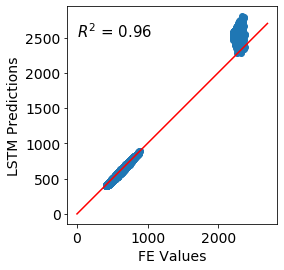

In [26]:
r2 = []
test_vec = plot_pred_scaled.reshape(1, 160000)[0]
pred_vec = plot_y_fe_scaled.reshape(1, 160000)[0]
r2.append(r2_score(pred_vec, test_vec))
err1 = sum(abs(pred_vec-test_vec))/40000
print(r2, err1)

plt.figure()
plt.rcParams.update({'font.size': 14})
a = plt.axes(aspect='equal')
a.text(0,2500, "$R^2$ = %0.2f"%(r2[0]), fontsize=15)
plt.scatter(plot_y_fe_scaled.reshape(1, 160000), plot_pred_scaled.reshape(1, 160000))
xp = [0,2700]
yp = xp
plt.plot(xp,yp, 'r')
plt.xlabel('FE Values')
plt.ylabel('LSTM Predictions')
plt.savefig(base_path+"/"+var_name+"_10-nohead.eps", format='eps')

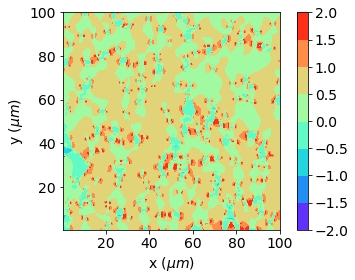

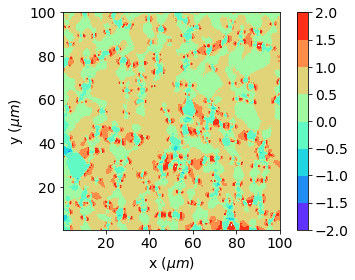

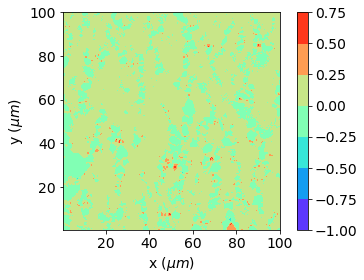

In [27]:
var_name = 'triaxiality'
plot_y_fe_scaled = plot_y_fe[-1:][:,320000:480000]
plot_y_fe_scaled = (plot_y_fe_scaled*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()

yy_levels = np.array([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])

# Contour of FE Values
xlist = np.arange(0.25, 100.25, 0.25)
ylist = np.arange(0.25, 100.25, 0.25)
X,Y = np.meshgrid(xlist, ylist)
Z = plot_y_fe_scaled.reshape(400, 400)
fig,ax=plt.subplots(1,1)
plt.rcParams.update({'font.size': 14})
mycmap1 = plt.get_cmap('rainbow')
cp = ax.contourf(X, Y, Z, cmap=mycmap1, levels=yy_levels)
cbar = fig.colorbar(cp) # Add a colorbar to a plot
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('x ($\mu m$)')
ax.set_ylabel('y ($\mu m$)')
plt.savefig(base_path+'/contour_cpfe_square_'+var_name+'.eps', format='eps')
yy_levels = cp.levels

var_name = 'triaxiality'
plot_pred_scaled = plot_pred[-1:][:,320000:480000]
plot_pred_scaled = (plot_pred_scaled*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
plot_pred_scaled

# Contour of LSTM Values
xlist = np.arange(0.25, 100.25, 0.25)
ylist = np.arange(0.25, 100.25, 0.25)
X,Y = np.meshgrid(xlist, ylist)
Z = plot_pred_scaled.reshape(400, 400)
fig,ax=plt.subplots(1,1)
plt.rcParams.update({'font.size': 14})
mycmap1 = plt.get_cmap('rainbow')
cp = ax.contourf(X, Y, Z, cmap=mycmap1, levels=yy_levels)
fig.colorbar(cp) 
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('x ($\mu m$)')
ax.set_ylabel('y ($\mu m$)')
plt.savefig(base_path+'/contour_pred_square_'+var_name+'.eps', format='eps')
yy_levels = cp.levels

# Contour of Error Values
plot_diff = (plot_pred_scaled - plot_y_fe_scaled)
xlist = np.arange(0.25, 100.25, 0.25)
ylist = np.arange(0.25, 100.25, 0.25)
X,Y = np.meshgrid(xlist, ylist)
Z = plot_diff.reshape(400, 400)
fig,ax=plt.subplots(1,1)
plt.rcParams.update({'font.size': 14})
mycmap1 = plt.get_cmap('rainbow')
cp = ax.contourf(X, Y, Z, cmap=mycmap1)
fig.colorbar(cp) 
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('x ($\mu m$)')
ax.set_ylabel('y ($\mu m$)')
plt.savefig(base_path+'/contour_error_square_'+var_name+'.eps', format='eps')

[0.9702705701209453] 0.1782527167361051


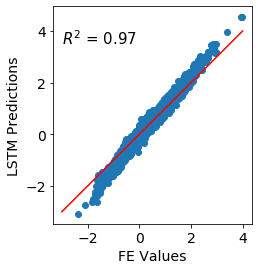

In [28]:
r2 = []
test_vec = plot_pred_scaled.reshape(1, 160000)[0]
pred_vec = plot_y_fe_scaled.reshape(1, 160000)[0]
r2.append(r2_score(pred_vec, test_vec))
err1 = sum(abs(pred_vec-test_vec))/40000
print(r2, err1)

plt.figure()
plt.rcParams.update({'font.size': 14})
a = plt.axes(aspect='equal')
a.text(-3,3.5, "$R^2$ = %0.2f"%(r2[0]), fontsize=15)
plt.scatter(plot_y_fe_scaled.reshape(1, 160000), plot_pred_scaled.reshape(1, 160000))
xp = [-3,4]
yp = xp
plt.plot(xp,yp, 'r')
#lims = [-0.01, 0.05]
#plt.xlim(lims)
#plt.ylim(lims)
#plt.title('triaxiality')
plt.xlabel('FE Values')
plt.ylabel('LSTM Predictions')
plt.savefig(base_path+"/"+var_name+"_10-noheadeps", format='eps')